In [1]:
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from recreate_icip2022_face_reconstruction.src.Network import Generator

In [2]:
# https://towardsdatascience.com/saliency-map-using-pytorch-68270fe45e80
# https://github.com/sijoonlee/deep_learning/blob/master/cs231n/NetworkVisualization-PyTorch.ipynb

In [3]:
length_of_embedding = 512
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_Generator = Generator(length_of_embedding=length_of_embedding)
generator_checkpoint = f"../recreate_icip2022_face_reconstruction/training_files/models/Generator_90.pth"
model_Generator.load_state_dict(
    torch.load(generator_checkpoint, map_location=device, )
)
model_Generator.to(device)

Generator(
  (dconv1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (BN_dconv1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN_conv1_1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN_conv1_2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN_conv1_3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BN_dconv2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [4]:
model_Generator.eval()

Generator(
  (dconv1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (BN_dconv1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN_conv1_1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN_conv1_2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN_conv1_3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BN_dconv2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [5]:
def transform_embedding(embedding):
    embedding = np.reshape(embedding, [embedding.shape[-1], 1, 1])
    embedding = torch.Tensor(embedding).to(device)
    embedding = embedding.unsqueeze(0)
    return embedding

def transform_image(image):
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.normalize(image, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    image = cv2.resize(image, (112, 112), interpolation=cv2.INTER_AREA)
    image = image.transpose(2, 0, 1)
    image = torch.Tensor(image).to(device)
    return image

In [6]:
image = transform_image("../data/lfw_align/Abel_Pacheco/Abel_Pacheco_0001.png")
embedding = np.load("../recreate_icip2022_face_reconstruction/experiments/experiment_11_pemiu_random/embedding_half/Abel_Pacheco_0001_106.npy")
embedding = transform_embedding(embedding)

In [7]:
embedding.shape

torch.Size([1, 512, 1, 1])

In [8]:
embedding.requires_grad = True

In [9]:
# Retrieve output from the image
output = model_Generator(embedding)

In [10]:
output.shape

torch.Size([1, 3, 112, 112])

In [11]:
output.squeeze().shape

torch.Size([3, 112, 112])

In [12]:
score, indices = torch.max(output, 1)

In [13]:
score.shape

torch.Size([1, 112, 112])

In [14]:
indices

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 2, 2, 2],
         [0, 0, 0,  ..., 2, 2, 2],
         [0, 0, 0,  ..., 2, 2, 2]]], device='cuda:0')

In [15]:
score.retain_grad()

In [16]:
score.backward(indices, retain_graph=True)

In [18]:
score.shape

torch.Size([1, 112, 112])

In [19]:
# Retrieve output from the image
#output = model_Generator(embedding)

# Catch the output
#output_idx = output.argmax(dim=2)
#output_max = output[0, 0, output_idx]

# Do backpropagation to get the derivative of the output based on the image
#output_max.backward()

In [28]:
score

tensor([[[0.4034, 0.3631, 0.3595,  ..., 0.3447, 0.3428, 0.3726],
         [0.3717, 0.3571, 0.3583,  ..., 0.3439, 0.3387, 0.3473],
         [0.3593, 0.3583, 0.3652,  ..., 0.3449, 0.3411, 0.3430],
         ...,
         [0.6622, 0.6594, 0.6511,  ..., 0.5144, 0.5489, 0.5389],
         [0.6379, 0.6459, 0.6421,  ..., 0.4824, 0.5222, 0.5022],
         [0.6150, 0.6282, 0.6306,  ..., 0.4160, 0.4446, 0.4238]]],
       device='cuda:0', grad_fn=<MaxBackward0>)

In [21]:
generated_image = model_Generator(embedding).detach().cpu()

In [22]:
im = (generated_image.squeeze().cpu().numpy().transpose(1, 2, 0) * 255).astype(int)

In [23]:
# Retireve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
#saliency, _ = torch.max(score.grad.data.abs(), dim=1) 
saliency = score.reshape(112, 112)

In [24]:
saliency

tensor([[0.4034, 0.3631, 0.3595,  ..., 0.3447, 0.3428, 0.3726],
        [0.3717, 0.3571, 0.3583,  ..., 0.3439, 0.3387, 0.3473],
        [0.3593, 0.3583, 0.3652,  ..., 0.3449, 0.3411, 0.3430],
        ...,
        [0.6622, 0.6594, 0.6511,  ..., 0.5144, 0.5489, 0.5389],
        [0.6379, 0.6459, 0.6421,  ..., 0.4824, 0.5222, 0.5022],
        [0.6150, 0.6282, 0.6306,  ..., 0.4160, 0.4446, 0.4238]],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

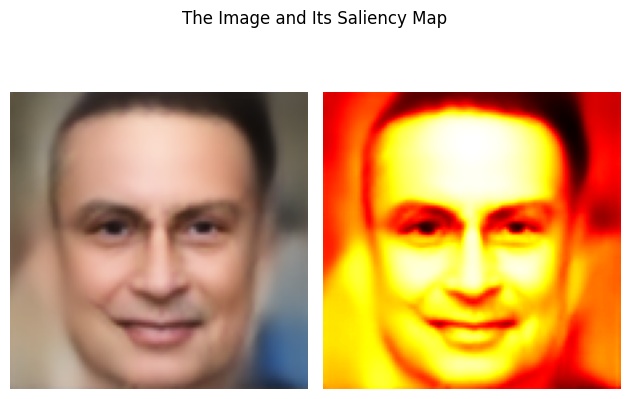

In [27]:
# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im)
ax[0].axis('off')
ax[1].imshow(saliency.cpu().detach().numpy(), cmap='hot')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()